# Detecção de Casos de COVID-19 em Tomografias (versão PyTorch)
**Agenda**
- Carregar dataset (ImageFolder)
- Pré-processamento e augmentations
- Transfer Learning (ResNet18)
- Treino, validação, checkpoint, early stopping
- Avaliação final e plots


In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()  # Envie o arquivo kaggle.json


Saving archive (3).zip to archive (3).zip


In [3]:
# Cell: Imports e configuração
import os
import random

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix

# Configurações
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [4]:
# Paths e hiper-parâmetros (ajuste aqui)
# DATA_DIR = "/kaggle/input"  # <-- ajuste para o caminho onde você extraiu o dataset
# The dataset was unzipped to /content/covid_dataset
DATA_DIR = "/content/covid_dataset"
# Espera-se uma estrutura: DATA_DIR/class1/*.png, DATA_DIR/class2/*.png (ImageFolder)
BATCH_SIZE = 16
IMG_SIZE = 224
NUM_EPOCHS = 25
LR = 2e-4
NUM_WORKERS = 4
PATIENCE = 6  # early stopping
MODEL_SAVE_PATH = "best_model_resnet18.pt"

In [5]:
import zipfile
import os

# Path to the uploaded zip file
zip_path = '/content/archive (3).zip'
# Directory where the dataset will be extracted
extract_base_path = '/content/covid_dataset'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_base_path):
    os.makedirs(extract_base_path)

# Unzip the file
print(f"Unzipping {zip_path} to {extract_base_path}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_base_path)

print("Unzipping complete.")

# Optional: List contents to verify structure and find the actual dataset root
print("Contents of extracted directory:")
for root, dirs, files in os.walk(extract_base_path):
    level = root.replace(extract_base_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        if not f.startswith('.'): # Ignore hidden files
            print(f'{subindent}{f}')
    if level > 1: # Limit depth for listing to avoid long output
        break

# The actual DATA_DIR should be adjusted based on the unzipped structure.
# Assuming the zip extracts into a folder named 'CT_Scan_Dataset' like:
# /content/covid_dataset/CT_Scan_Dataset/COVID
# /content/covid_dataset/CT_Scan_Dataset/Non-COVID
# The DATA_DIR variable is updated in cell 'nPLXoMoN7YCI' to reflect this.

Unzipping /content/archive (3).zip to /content/covid_dataset...
Unzipping complete.
Contents of extracted directory:
covid_dataset/
    COVID/
        Covid (512).png
        Covid (583).png
        Covid (931).png
        Covid (613).png
        Covid (522).png
        Covid (149).png
        Covid (177).png
        Covid (449).png
        Covid (704).png
        Covid (96).png
        Covid (1155).png
        Covid (1090).png
        Covid (1063).png
        Covid (926).png
        Covid (1024).png
        Covid (341).png
        Covid (79).png
        Covid (468).png
        Covid (820).png
        Covid (314).png
        Covid (738).png
        Covid (1011).png
        Covid (216).png
        Covid (989).png
        Covid (723).png
        Covid (202).png
        Covid (655).png
        Covid (941).png
        Covid (450).png
        Covid (1137).png
        Covid (1031).png
        Covid (81).png
        Covid (132).png
        Covid (602).png
        Covid (313).png
        Covid

In [6]:
# Augmentations e transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Carregar todo dataset via ImageFolder
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names, "Num classes:", num_classes)

# Split train / val (ex.: 80/20)
val_ratio = 0.2
n_total = len(full_dataset)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

train_dataset, val_dataset = random_split(
    full_dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(SEED)
)

# Aplica a transformação de validação ao conjunto de validação
# Isso é necessário porque `random_split` herda a transformação do `full_dataset`
# que é `train_transform`. Precisamos aplicar `val_transform` ao `val_dataset`.
val_dataset.dataset.transform = val_transform

print(f"Tamanho train: {len(train_dataset)}, val: {len(val_dataset)}")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Classes: ['COVID', 'non-COVID'] Num classes: 2
Tamanho train: 1985, val: 496


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
# Model (Transfer Learning com ResNet18)
def build_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    # Congelar todos os parâmetros do modelo pré-treinado
    for param in model.parameters():
        param.requires_grad = False

    # Substituir a camada final (fully connected) para nosso número de classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(DEVICE)
    return model

model = build_model(num_classes)
print(model)

# Loss e Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LR) # Apenas camada final treinável

# Scheduler para ajuste do Learning Rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=PATIENCE // 2
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Train", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data).item()
        total += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Val", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()
            total += inputs.size(0)

            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc, all_preds, all_labels


In [9]:
best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, DEVICE)
    scheduler.step(val_loss)  # opcional

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f" train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}")
    print(f" val_loss:   {val_loss:.4f} val_acc:   {val_acc:.4f}")

    # Checkpoint by val_loss (mudar se preferir val_acc)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'class_names': class_names
        }, MODEL_SAVE_PATH)
        print(" Saved best model.")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f" Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print("Early stopping triggered.")
        break

print("Treino finalizado. Best val_loss:", best_val_loss, "best val_acc:", best_val_acc)


Epoch 1/25


 train_loss: 0.6174 train_acc: 0.6650
 val_loss:   0.5535 val_acc:   0.7258
 Saved best model.
Epoch 2/25


 train_loss: 0.5246 train_acc: 0.7476
 val_loss:   0.4785 val_acc:   0.7843
 Saved best model.
Epoch 3/25


 train_loss: 0.4648 train_acc: 0.8091
 val_loss:   0.4396 val_acc:   0.8125
 Saved best model.
Epoch 4/25


 train_loss: 0.4297 train_acc: 0.8081
 val_loss:   0.4083 val_acc:   0.8306
 Saved best model.
Epoch 5/25


 train_loss: 0.4118 train_acc: 0.8302
 val_loss:   0.3915 val_acc:   0.8387
 Saved best model.
Epoch 6/25


 train_loss: 0.3956 train_acc: 0.8252
 val_loss:   0.3704 val_acc:   0.8488
 Saved best model.
Epoch 7/25


 train_loss: 0.3698 train_acc: 0.8453
 val_loss:   0.3637 val_acc:   0.8589
 Saved best model.
Epoch 8/25


 train_loss: 0.3671 train_acc: 0.8458
 val_loss:   0.3478 val_acc:   0.8508
 Saved best model.
Epoch 9/25


 train_loss: 0.3618 train_acc: 0.8524
 val_loss:   0.3726 val_acc:   0.8327
 Patience: 1/6
Epoch 10/25


 train_loss: 0.3546 train_acc: 0.8448
 val_loss:   0.3310 val_acc:   0.8710
 Saved best model.
Epoch 11/25


 train_loss: 0.3326 train_acc: 0.8690
 val_loss:   0.3269 val_acc:   0.8609
 Saved best model.
Epoch 12/25


 train_loss: 0.3492 train_acc: 0.8484
 val_loss:   0.3237 val_acc:   0.8609
 Saved best model.
Epoch 13/25


 train_loss: 0.3352 train_acc: 0.8625
 val_loss:   0.3184 val_acc:   0.8710
 Saved best model.
Epoch 14/25


 train_loss: 0.3168 train_acc: 0.8741
 val_loss:   0.3115 val_acc:   0.8810
 Saved best model.
Epoch 15/25


 train_loss: 0.3205 train_acc: 0.8615
 val_loss:   0.3026 val_acc:   0.8730
 Saved best model.
Epoch 16/25


 train_loss: 0.3290 train_acc: 0.8589
 val_loss:   0.3026 val_acc:   0.8790
 Patience: 1/6
Epoch 17/25


 train_loss: 0.3177 train_acc: 0.8695
 val_loss:   0.3028 val_acc:   0.8770
 Patience: 2/6
Epoch 18/25


 train_loss: 0.3108 train_acc: 0.8776
 val_loss:   0.2897 val_acc:   0.9012
 Saved best model.
Epoch 19/25


 train_loss: 0.3120 train_acc: 0.8746
 val_loss:   0.2858 val_acc:   0.8871
 Saved best model.
Epoch 20/25


 train_loss: 0.2996 train_acc: 0.8746
 val_loss:   0.2875 val_acc:   0.8851
 Patience: 1/6
Epoch 21/25


 train_loss: 0.2998 train_acc: 0.8796
 val_loss:   0.3044 val_acc:   0.8649
 Patience: 2/6
Epoch 22/25


 train_loss: 0.2956 train_acc: 0.8836
 val_loss:   0.3159 val_acc:   0.8569
 Patience: 3/6
Epoch 23/25


 train_loss: 0.2996 train_acc: 0.8741
 val_loss:   0.2745 val_acc:   0.8992
 Saved best model.
Epoch 24/25


 train_loss: 0.2828 train_acc: 0.8831
 val_loss:   0.2752 val_acc:   0.8972
 Patience: 1/6
Epoch 25/25


 train_loss: 0.2808 train_acc: 0.8892
 val_loss:   0.2711 val_acc:   0.9032
 Saved best model.
Treino finalizado. Best val_loss: 0.27112853094454736 best val_acc: 0.9032258064516129


In [10]:
# Carregar melhor checkpoint
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model.eval()

# Rodar validação final para obter previsões
val_loss, val_acc, preds, labels = validate(model, val_loader, criterion, DEVICE)
print("Val loss:", val_loss, "Val acc:", val_acc)

# Relatório
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=class_names))

# Matriz de confusão
cm = confusion_matrix(labels, preds)
print("Confusion Matrix:\n", cm)


Val loss: 0.27112853094454736 Val acc: 0.9032258064516129

Classification Report:
              precision    recall  f1-score   support

       COVID       0.93      0.86      0.89       231
   non-COVID       0.88      0.94      0.91       265

    accuracy                           0.90       496
   macro avg       0.91      0.90      0.90       496
weighted avg       0.90      0.90      0.90       496

Confusion Matrix:
 [[198  33]
 [ 15 250]]


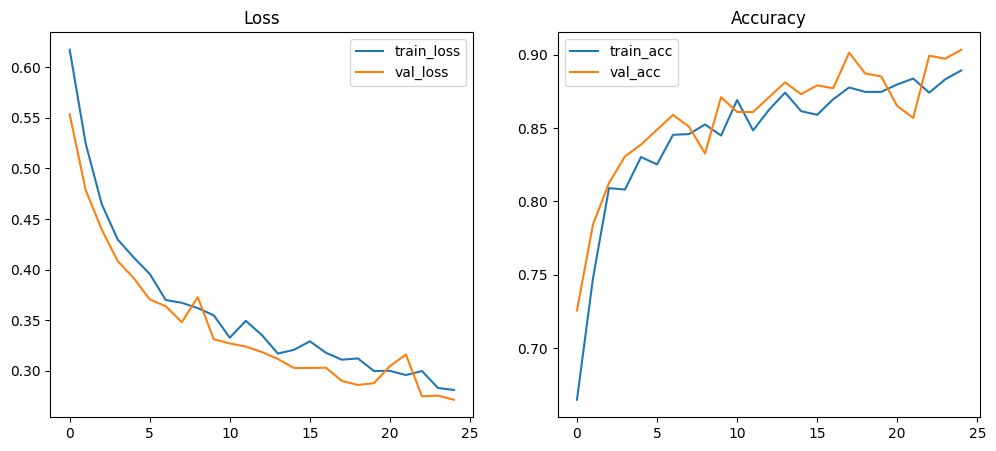

In [11]:
# Plots simples
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.legend()
plt.title('Accuracy')

plt.show()


In [13]:
# Salvar classes em arquivo para referência futura
import json
with open("class_names.json", "w") as f:
    json.dump(class_names, f, ensure_ascii=False, indent=2)
print("Class names saved to class_names.json")

print("Pronto. Para testar previsões individuais, carregue imagem, aplique val_transform e execute model(img.unsqueeze(0)).")


Class names saved to class_names.json
Pronto. Para testar previsões individuais, carregue imagem, aplique val_transform e execute model(img.unsqueeze(0)).
